<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/tf-v2/live-coding-intro-twitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Live Coding Neural Networks with TensorFlow 2 on Twitch for Manning

In this stream you will get an introduction into neural networks from first principals using TensorFlow 2. 

From its low level API we will work our way up to its high level Keras API solving the same simple challenge. 

<img src='https://github.com/djcordhose/deep-learning-crash-course-notebooks/blob/master/tf-v2/twitch.png?raw=1'>

https://www.twitch.tv/manningpublications @5/05 (9am PST, 12pm EST, 18:00 GMT+2)

***This notebook: https://bit.ly/tf-manning-on-twitch***

Schedule and Questions: 
https://freecontent.manning.com/manning-on-twitch-calendar-live-author-appearances/

## Video Course

<a href='https://www.manning.com/livevideo/deep-learning-crash-course'>
<img src='https://github.com/djcordhose/deep-learning-crash-course-notebooks/blob/master/livevideo-deep-learning-crash-course.png?raw=1' height='200'>
</a>

https://www.manning.com/livevideo/deep-learning-crash-course, 40% off on all products using code **twitzeig40**

Oliver Zeigermann, <a href='http://zeigermann.eu/'>zeigermann.eu/</a>, <a href='https://twitter.com/DJCordhose'>@DJCordhose</a>

## Links
* Notebooks for the video course updated to TensorFlow 2: https://github.com/DJCordhose/deep-learning-crash-course-notebooks#tensorflow-2

* More content on the Manning Channel: https://freecontent.manning.com/manning-on-twitch-calendar-live-author-appearances/

_Feel free to execute all cells in sync with the talk or just watch and listen_

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

# We begin with a plot of a dependent variable

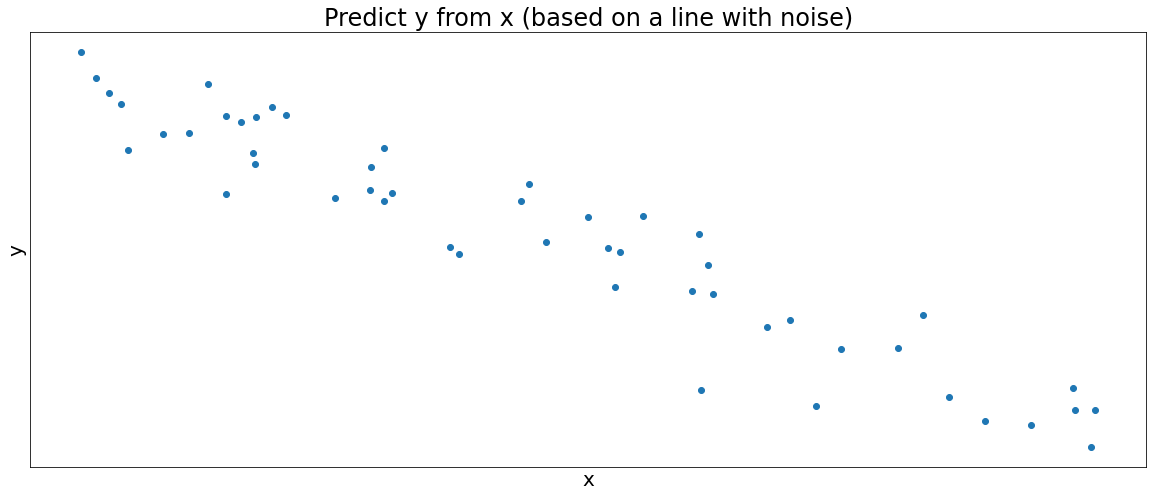

In [3]:
#@title A noisy line of shape y = m*x + b { run: "auto", display-mode: "form" }

# https://colab.research.google.com/notebooks/forms.ipynb

n = 50 #@param {type:"slider", min:10, max:500, step:1}
m = -1 #@param {type:"slider", min:-10, max:10, step: 0.1}
b = 1 #@param {type:"slider", min:-10, max:10, step: 0.1}

noise_level = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}

title = 'Predict y from x (based on a line with noise)' #@param {type:"string"}
x_label = 'x' #@param {type:"string"}
y_label = 'y' #@param {type:"string"}

import numpy as np
np.random.seed(42)

# sort is not necessary, but makes x easier to understand
x = np.sort(np.random.uniform(0, 1, n))
y = m*x+b + np.random.normal(0, noise_level, n)

plt.xlabel(x_label)
plt.ylabel(y_label)

plt.xticks([])
plt.yticks([])

plt.title(title)

plt.scatter(x, y);

## Let's find a matching example

_Let's change the title and what is on the axis to match our application_

# _Challenge: How do we fit the best line possible?_

* Maybe to predict the future
* Or understand the nature of the data

_Having a **line** is our prior believe, we will later remove this assumption_ 

# Starting off with a naive approach

## Our model: linear

### ```y = m*x + b```

* `m` is the slope 
* `b` is the y-intercept


In [0]:
class LinearModel:
  
  def __init__(self, m=0, b=0):
    self.m = m
    self.b = b
    
  def __call__(self, x):
    y = self.m * x + self.b
    return y

In [5]:
x

array([0.02058449, 0.03438852, 0.04645041, 0.05808361, 0.06505159,
       0.09767211, 0.12203823, 0.13949386, 0.15599452, 0.15601864,
       0.17052412, 0.18182497, 0.18340451, 0.18485446, 0.19967378,
       0.21233911, 0.25877998, 0.29122914, 0.29214465, 0.30424224,
       0.30461377, 0.31171108, 0.36636184, 0.37454012, 0.43194502,
       0.44015249, 0.45606998, 0.49517691, 0.51423444, 0.52006802,
       0.52475643, 0.54671028, 0.59241457, 0.59865848, 0.60111501,
       0.60754485, 0.61185289, 0.66252228, 0.68423303, 0.70807258,
       0.73199394, 0.78517596, 0.80839735, 0.83244264, 0.86617615,
       0.9093204 , 0.94888554, 0.95071431, 0.96563203, 0.96990985])

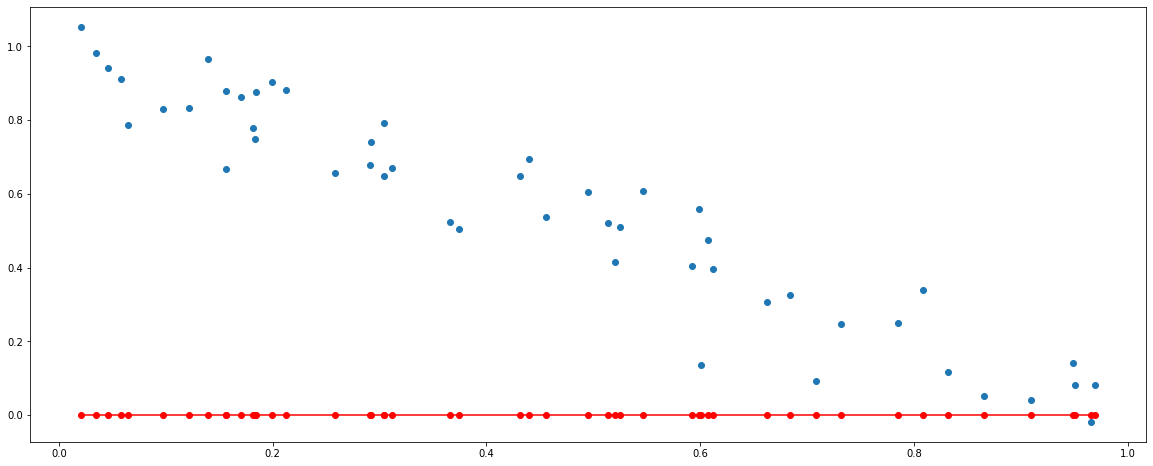

In [6]:
model = LinearModel()
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## How wrong are we?
### This is obviously wrong, but how wrong are we?

In [7]:
def loss1(y_true, y_pred):
  return np.sum(y_true - y_pred)
loss1(y, y_pred)

27.689078353052434

In [8]:
def loss_no_negative(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred))
loss_no_negative(y, y_pred)

27.72629445995496

In [9]:
def loss_no_negative_normalize(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / len(y_true)
loss_no_negative_normalize(y, y_pred)

0.5545258891990992

## Approach: Trying to bring the loss down in loop

Parameters to tweak
* m for the slope
* b for the y-intercept

### Let's begin with naive implementation

1. if we bring m or b up or down, does this improve the loss?
1. if so, do it
1. rinse and repeat for a number of times

In [10]:
model = LinearModel()

EPOCHS = 500
learning_rate = 0.01

losses = []

for step in range(EPOCHS):
  y_pred = model(x)
  
  loss = loss_no_negative_normalize(y, y_pred)
    
  # just for logging
  losses.append(loss)
  
  # let's try m
  new_model = LinearModel(m = model.m + learning_rate, b = model.b)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.m += learning_rate
  else:
    model.m -= learning_rate
    
  # then b
  new_model = LinearModel(m = model.m, b = model.b + learning_rate)
  new_y_pred = new_model(x)
  new_loss = loss_no_negative_normalize(y, new_y_pred)
  
  if new_loss < loss:
    model.b += learning_rate
  else:
    model.b -= learning_rate


"slope (m): {}, y-intercept (b): {}".format(model.m, model.b)    

'slope (m): -0.9400000000000006, y-intercept (b): 0.9600000000000006'

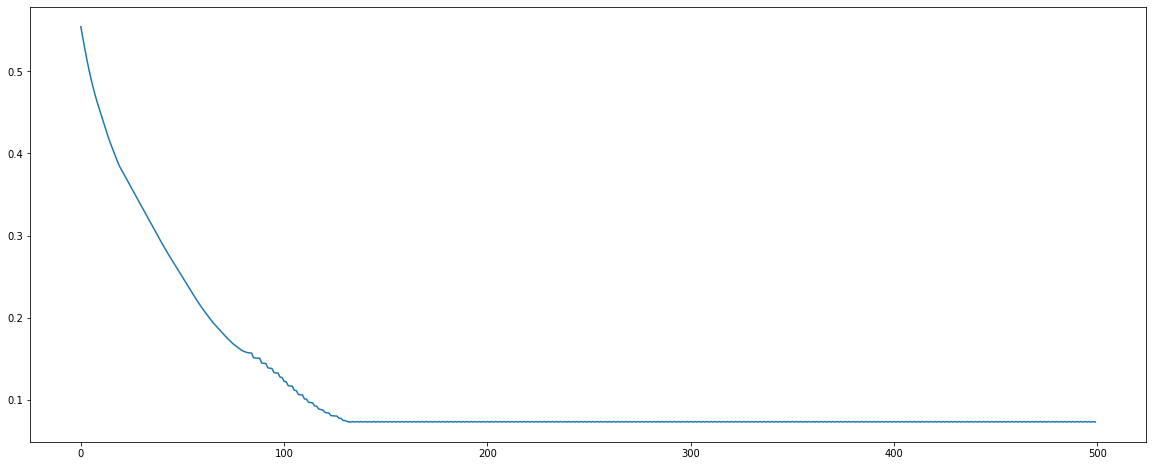

In [11]:
# plt.yscale('log')
plt.plot(losses);

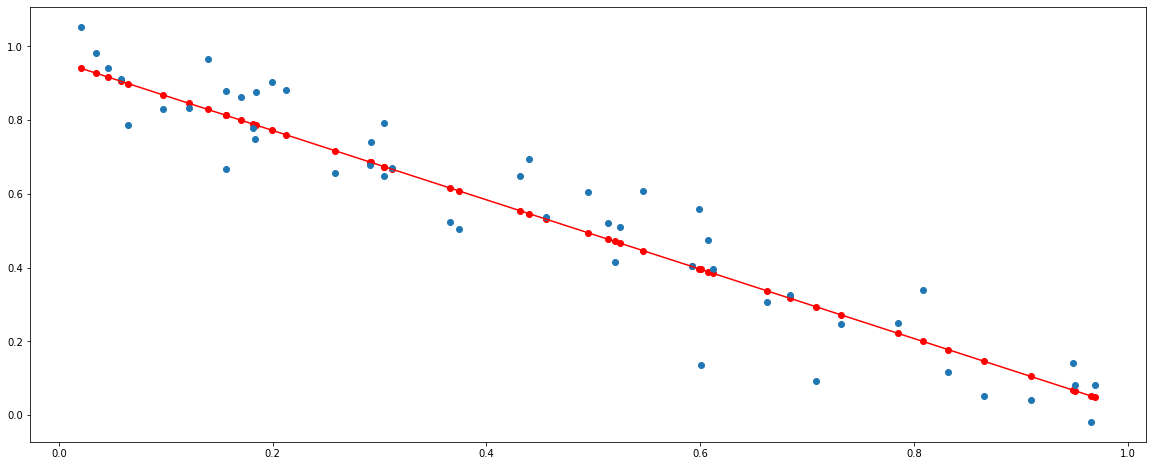

In [12]:
y_pred = model(x)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

# We already have a working solution

## But does this scale to an example with many more parameters and more inputs?

1. Calculating the output might be expensive
2. Trying out all parameters in a random way like we do would have a bad performance for a large problem
3. Wouldn't we also need to try them in combination?

# Let's see what we need to change for this to become a state of the art neural network using TensorFlow 2

1. Replace our model with a fully connected layer
2. Use a standard loss function
3. Finding parameters to tune in a more efficient way
4. Changing parameters in a more subtle way

In [13]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.2.0-rc3'

In [0]:
tf.random.set_seed(42)

In [15]:
!nvidia-smi

Sat May  2 16:42:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Step one: use a dense layer instead of our simple model
* Scales well for as many neurons and inputs as we want
* Remember: for now we are assuming a line, but this is a prior that might not be necessary
* Efficient implementation on GPUs



### The Artificial Neuron: Foundation of Deep Neural Networks

<img src='https://djcordhose.github.io/ai/img/insurance/neuron211.jpg'>

### Defining a dense layer with a random number of neurons and inputs

With a little more work this would be a complete implementation of a fully connected layer



In [16]:
from tensorflow.keras.layers import Layer

# we derive from a TensorFlow Layer
class LinearLayer(Layer):
  """y = w.x + b"""

  # initializing our layer
  def __init__(self, units=1, input_dim=1):
      super(LinearLayer, self).__init__()
      # these are our weights, which can be learned, initialized normally around 0 with stddev of 2
      self.w = tf.Variable(
          initial_value = tf.random_normal_initializer(stddev=2)(shape=(input_dim, units), dtype='float32'),
          trainable=True,
          name='weights')
      # these are our bisases, also can be learned, initialized as 0
      self.b = tf.Variable(
          initial_value = tf.zeros_initializer()(shape=(units,), dtype='float32'),
          trainable=True,
          name='biases')

  # the layer does: calculating the output of a neuron
  def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b
    
# just one neuron and one input (but could be as many as we like)    
linear_layer = LinearLayer()
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[0.654937]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### Same prediction as before, but now on GPU using scalable matrix multiplcation

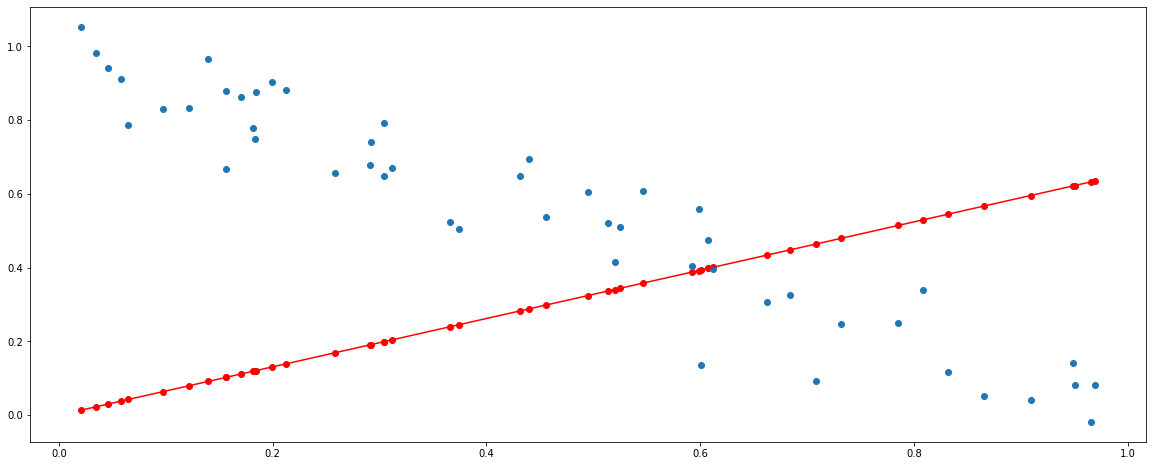

In [17]:
x_tensor = tf.reshape(tf.constant(x, dtype=tf.float32), (n, 1))
y_tensor = tf.reshape(tf.constant(y, dtype=tf.float32), (n, 1))

y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

### you can see slope and offset are just not right, because they have been initialized randomly


In [18]:
"slope (m): {}, y-intercept (b): {}".format(linear_layer.w.numpy()[0], linear_layer.b.numpy()[0])    

'slope (m): [0.654937], y-intercept (b): 0.0'

## Step two: use standard loss and metric
* what we defined is called mean absolute error: mae
* mean squared error is more common, it squares the differences and gives high values a larger weight: mse
* both are pre-defined efficiently in TensorFlow 2

### Mean Squared Error

emphasizes larger errors

$MSE = {\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}$


https://en.wikipedia.org/wiki/Mean_squared_error


In [19]:
tf.losses.mean_squared_error(y_true=tf.squeeze(y), y_pred=tf.squeeze(y_pred)).numpy()

0.2960563

### R2 Metric: MSE and MAE are not speaking

* Loss functions need to be differentiable (you will see later why)
* This often restricts how speaking they are in terms of business value
* Metrics do not have that resriction, but take the same parameters
* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


In [0]:
# https://keras.io/metrics/#custom-metrics
# https://www.tensorflow.org/tutorials/customization/performance
  
# ported to TF 2 from 
# * https://stackoverflow.com/a/42351397/1756489 and
# * https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019 (for use of epsilon to avoid strange inf or -inf)

# only works properly on tensors

@tf.function
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, tf.add(total_error, tf.keras.backend.epsilon())))
  
  return R_squared

In [21]:
r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)).numpy()

-2.394756

## Step three: Finding parameters to tune

## Backpropagation algorithm


### The core of how a neural network learns

_In a nutshell:_
1. Predict: Let the network make a prediction 
1. Calculate the loss: how accurate was the predition
1. Record a function of how the trainable parameters affect the loss 
1. partial derivations: find out in which direction to change each of the parameters to bring down the loss
1. Optimizer: Make changes to parameters based on learning rate and other parameters


### Loss depends on the trainable variables, in our case two parameters: weight and bias

This is how the loss function might change depending on those variables

<img src='https://djcordhose.github.io/ai/img/gradients.jpg'>

https://twitter.com/colindcarroll/status/1090266016259534848

In [22]:
linear_layer.trainable_variables

[<tf.Variable 'weights:0' shape=(1, 1) dtype=float32, numpy=array([[0.654937]], dtype=float32)>,
 <tf.Variable 'biases:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

### For this we need partial derivations

TensorFlow offers automatic differentiation: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape

* tape will record operations for automatic differentiation
* either by making it record explicily (watch) or 
* by declaring a varible to be trainable (which we did in the layer above) 



In [0]:
from tensorflow import GradientTape 
# GradientTape?

In [24]:
def tape_sample():
  x = tf.Variable(3.0)
  with tf.GradientTape() as tape:
    y = x * x
  print("x: {}, y:{}".format(x.numpy(), y.numpy()))
  # how is y dependending on x
  dy_dx = tape.gradient(y, x)
  print("dy/dx: {}".format(dy_dx.numpy()))
  
# just a function in order not to interfere with x on the global scope  
tape_sample()

x: 3.0, y:9.0
dy/dx: 6.0


## Intermediate solution: applying all this to our training loop

In [0]:
linear_layer = LinearLayer()

EPOCHS = 1500
learning_rate = 0.01

losses = []
r2s = []

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    # often we do not use all data to calculate the loss, but only a certain fraction, called the batch
    # you could also push data through one by one, being an extreme version of a batched approached
    # in our case we use all the data we have and calculate the combined error
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # get gradients of weights wrt the loss
  (dw, db) = tape.gradient(loss, linear_layer.trainable_weights)
  
  # optimizer: backward pass, changing trainable weights in the direction of the mimimum
  linear_layer.w.assign_sub(learning_rate * dw)
  linear_layer.b.assign_sub(learning_rate * db)

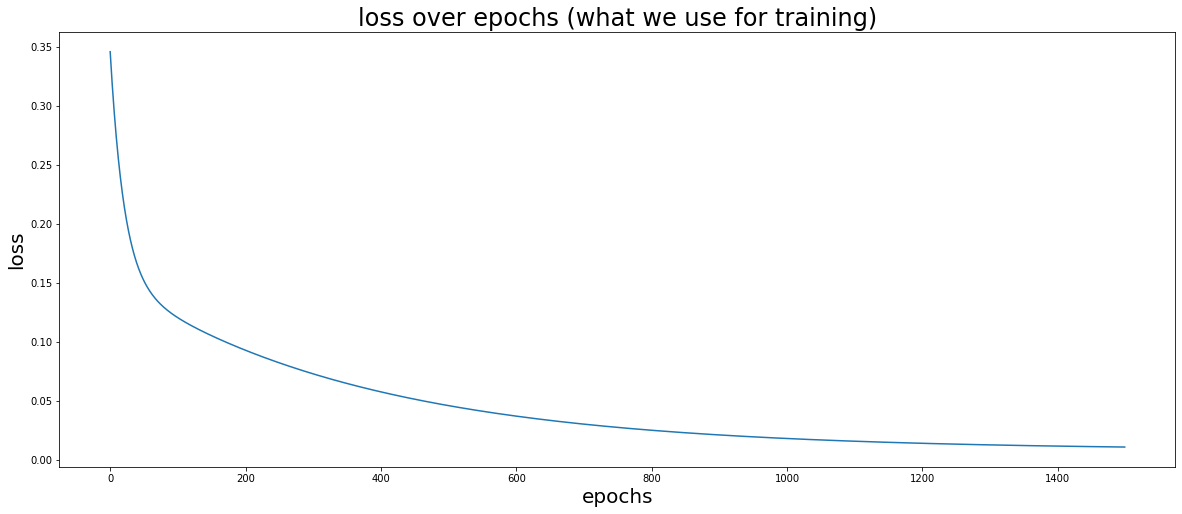

In [26]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss over epochs (what we use for training)')

# plt.yscale('log')

plt.plot(losses);

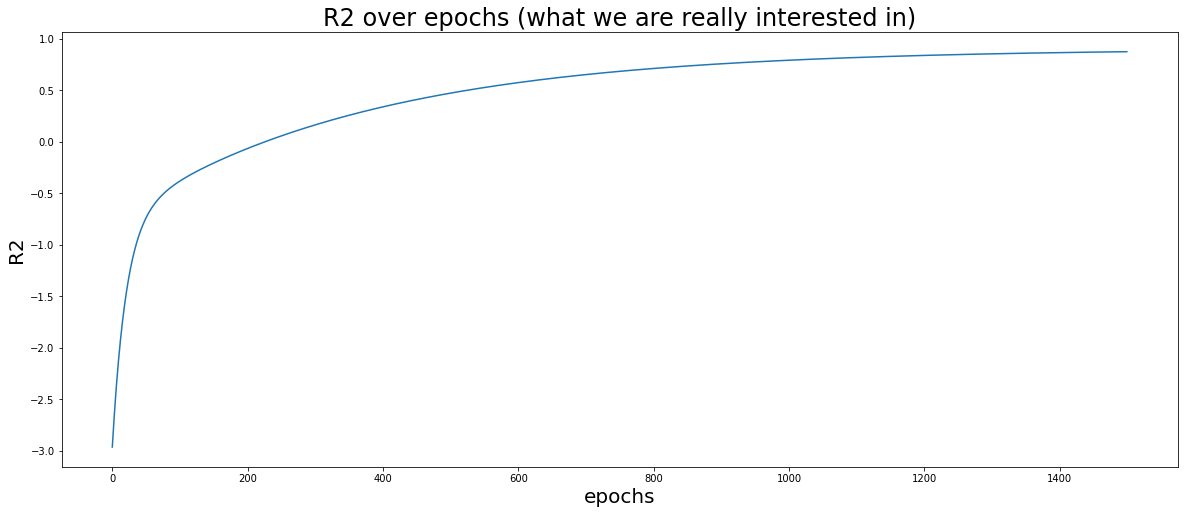

In [27]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2 over epochs (what we are really interested in)')

plt.plot(r2s);

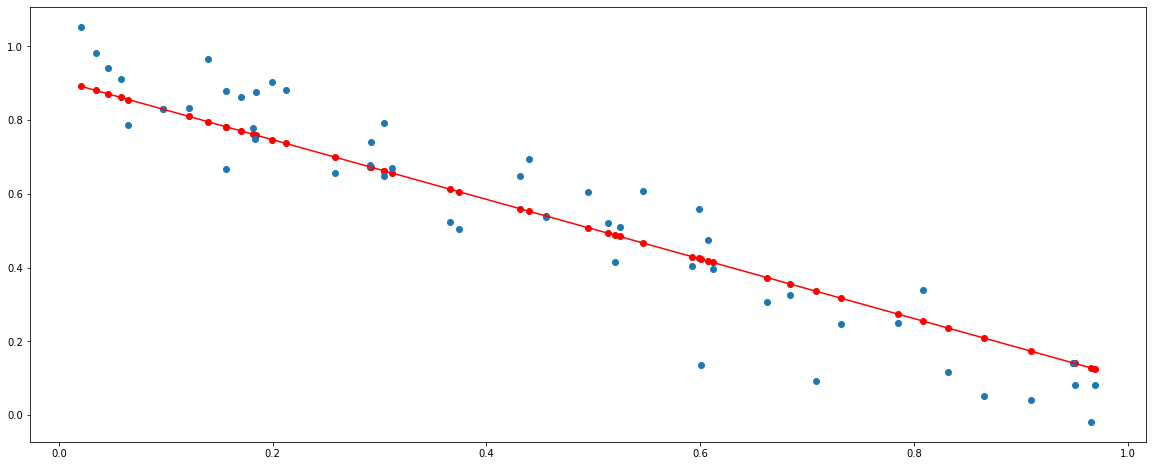

In [28]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## Final step: Changing parameters

## Prebuilt Optimizers do this job (but a bit more efficient and sohpisticated)

* http://cs231n.github.io/optimization-1/
* http://cs231n.github.io/neural-networks-3/#update
* How they sound: http://blog.christianperone.com/2019/08/listening-to-the-neural-network-gradient-norms-during-training/

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)

In [0]:
EPOCHS = 1500

losses = []
r2s = []

linear_layer = LinearLayer()

for step in range(EPOCHS):
  with tf.GradientTape() as tape:

    # forward pass, all data
    y_pred = linear_layer(x_tensor)

    # loss for this batch
    loss = tf.losses.mean_squared_error(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred))
    
  # just for logging
  losses.append(loss)
  
  # metrics
  r2s.append(r2_metric(y_true=tf.squeeze(y_tensor), y_pred=tf.squeeze(y_pred)))

  # Get gradients of weights wrt the loss.
  gradients = tape.gradient(loss, linear_layer.trainable_weights)
  
  # Update the weights of our linear layer.
  optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))

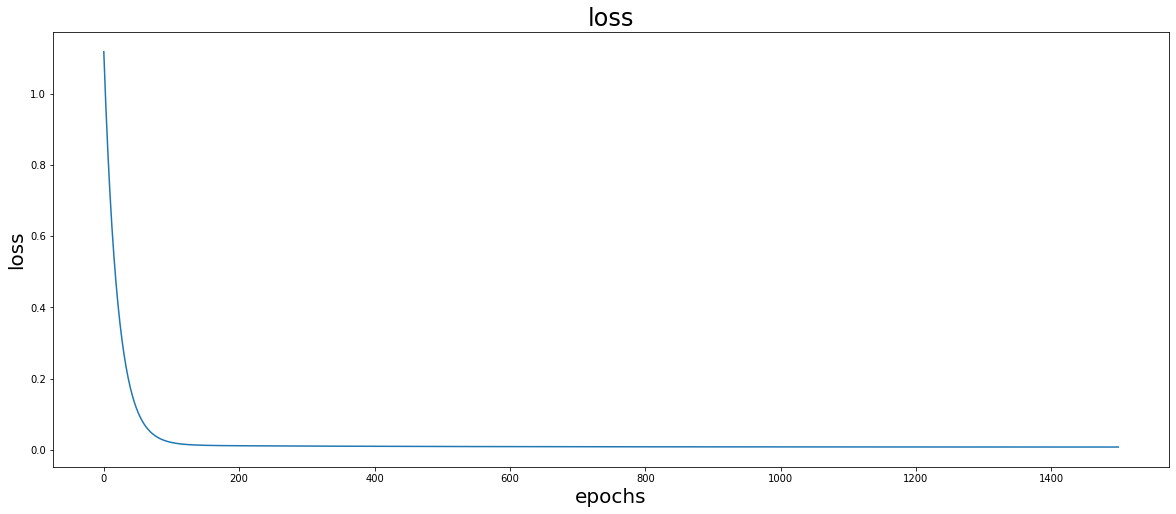

In [31]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('loss')

plt.plot(losses);

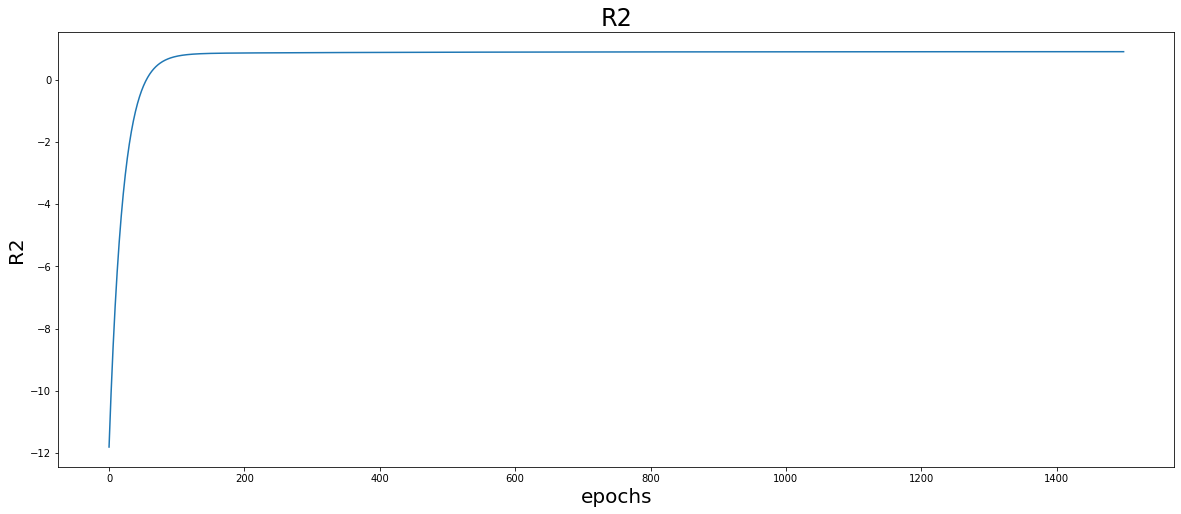

In [32]:
plt.xlabel('epochs')
plt.ylabel('R2')
plt.title('R2')

plt.plot(r2s);

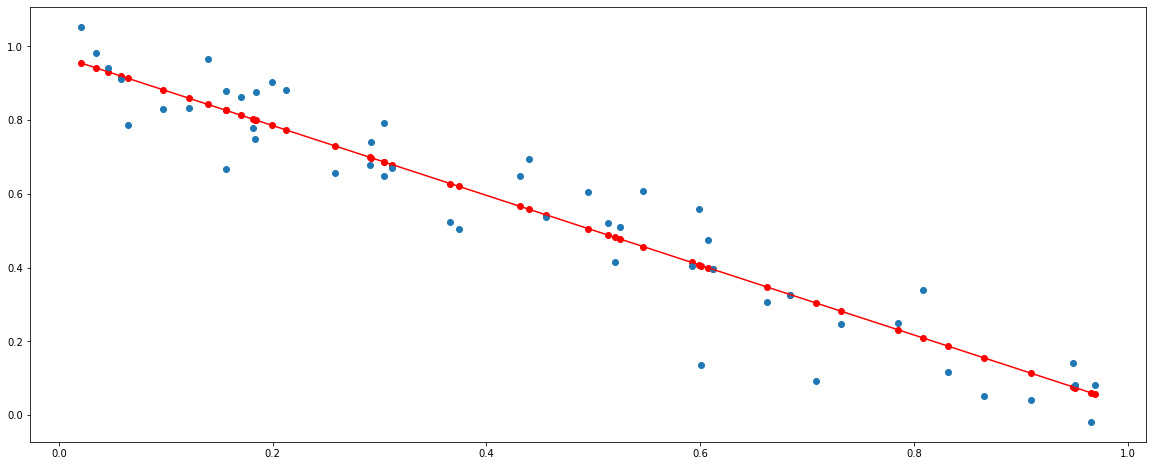

In [33]:
y_pred = linear_layer(x_tensor)
plt.plot(x, y_pred, color='r')
plt.scatter(x, y_pred, color='r')
plt.scatter(x, y);

## The same solution using high level Keas API

## Keras vs TensorFlow

<img src='https://github.com/DJCordhose/ml-workshop/blob/master/notebooks/tf-intro/keras-vs-tensorflow.jpg?raw=1'>

https://twitter.com/fchollet at http://scaledml.org/2020/

In [34]:
from tensorflow.keras.layers import Dense
 
model = tf.keras.Sequential([
  Dense(units=1, input_dim=1)                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time 

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

CPU times: user 6.64 s, sys: 922 ms, total: 7.57 s
Wall time: 5.75 s


In [36]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.01029820553958416, 0.6055195331573486)

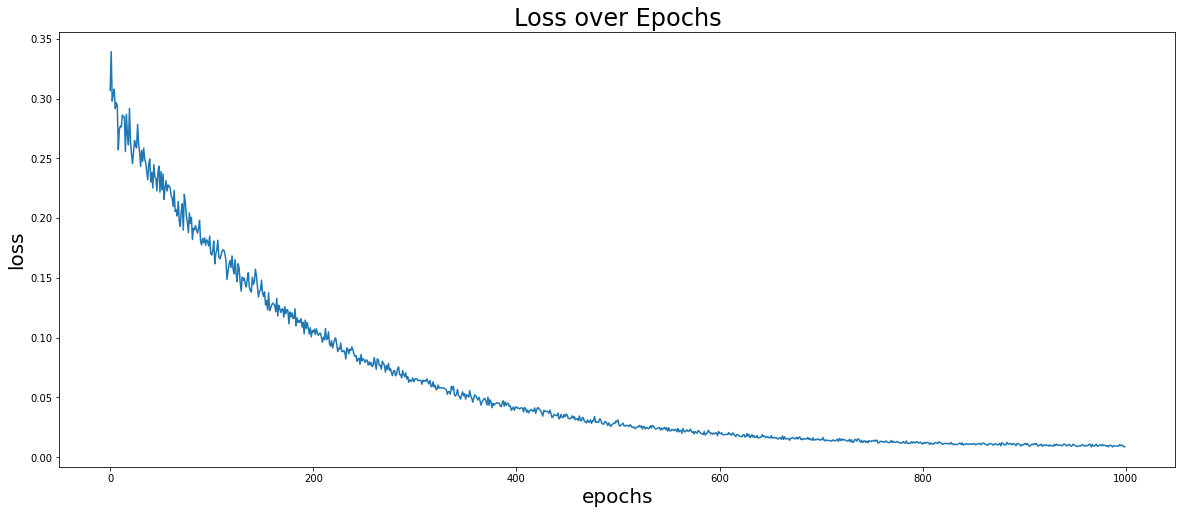

In [37]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs')

plt.plot(history.history['loss']);

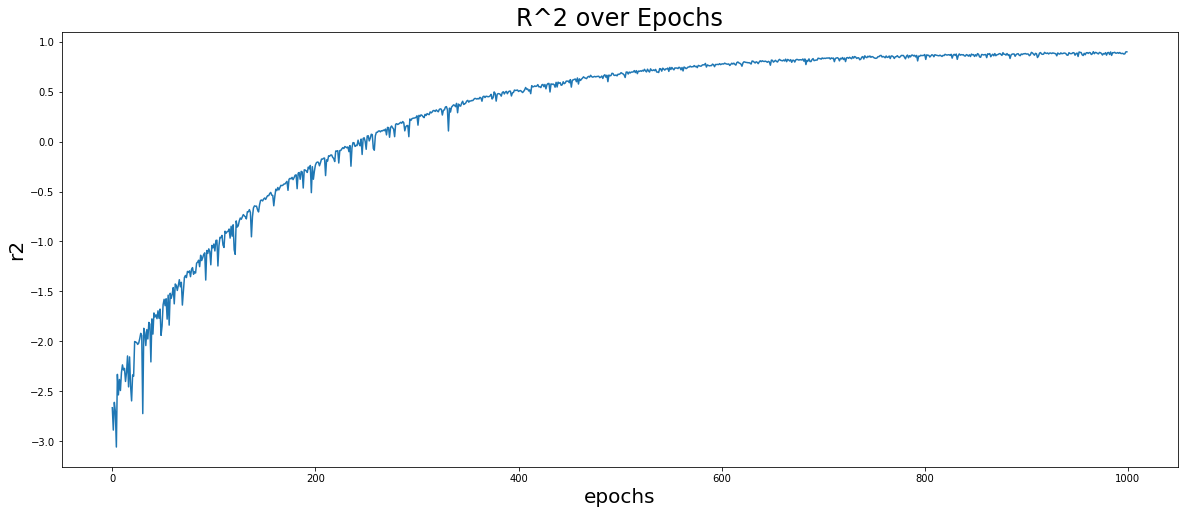

In [38]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

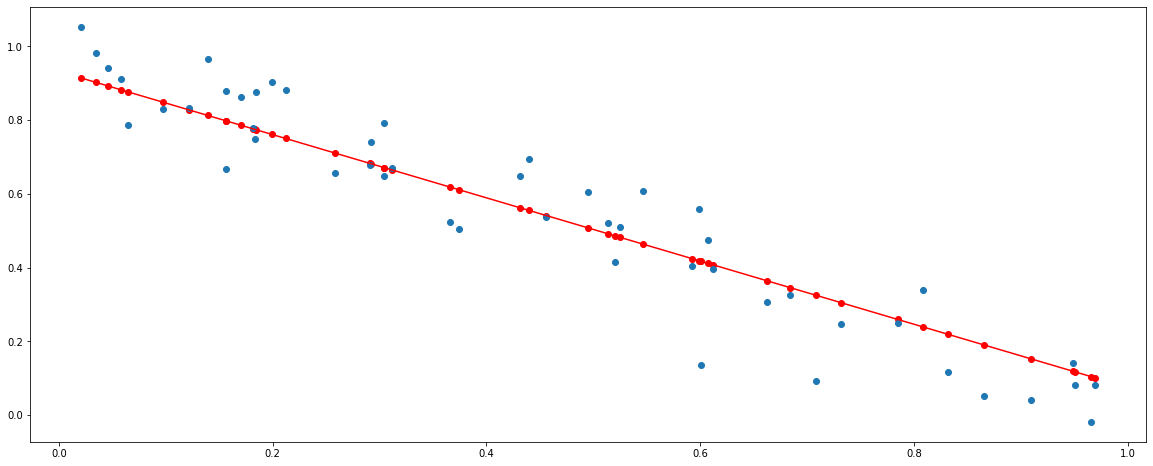

In [39]:
y_pred = model.predict(x)
plt.plot(x, y_pred, color='red')
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

## Neural Networks with 2-3 Layers can learn to approximate any function
* no additional prior required
* theoretically only one layer is enough, but this will not always train

<img src='https://github.com/djcordhose/deep-learning-crash-course-notebooks/blob/master/tf-v2/nn-from-layer-to-model.png?raw=1'>

In [40]:
%%time 
 
model = tf.keras.Sequential([
  Dense(units=100, activation='relu', input_dim=1),                   
  Dense(units=100, activation='relu'),
  Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='linear')                   
])
model.summary()

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.Adam(), # Adam is a bit more powerful, but this could also be SGD
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 7.58 s, sys: 1.03 s, total: 8.62 s
Wall time: 6.62 s


In [41]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.00825192965567112, 0.6840049624443054)

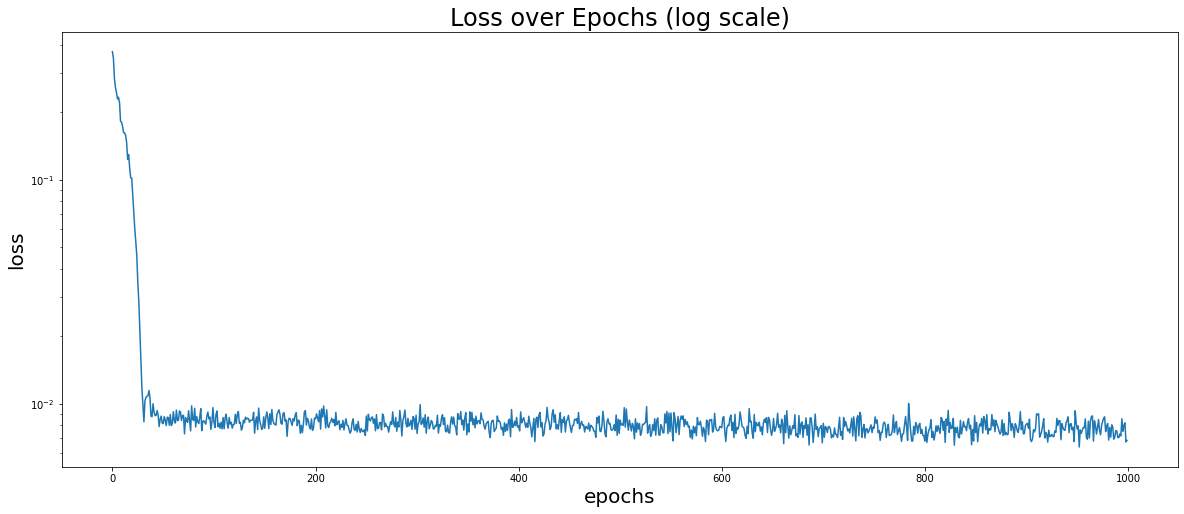

In [42]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

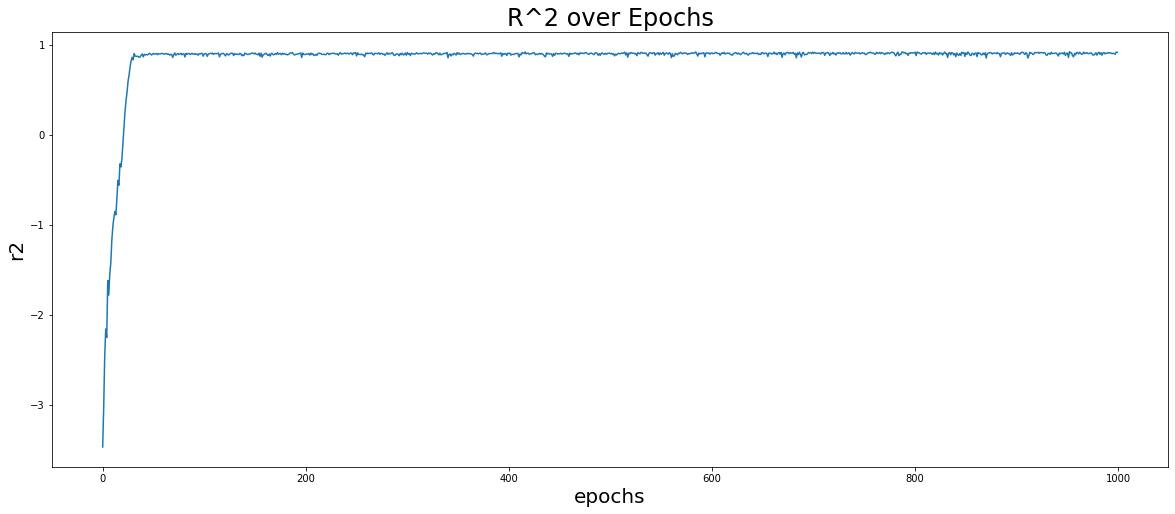

In [43]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

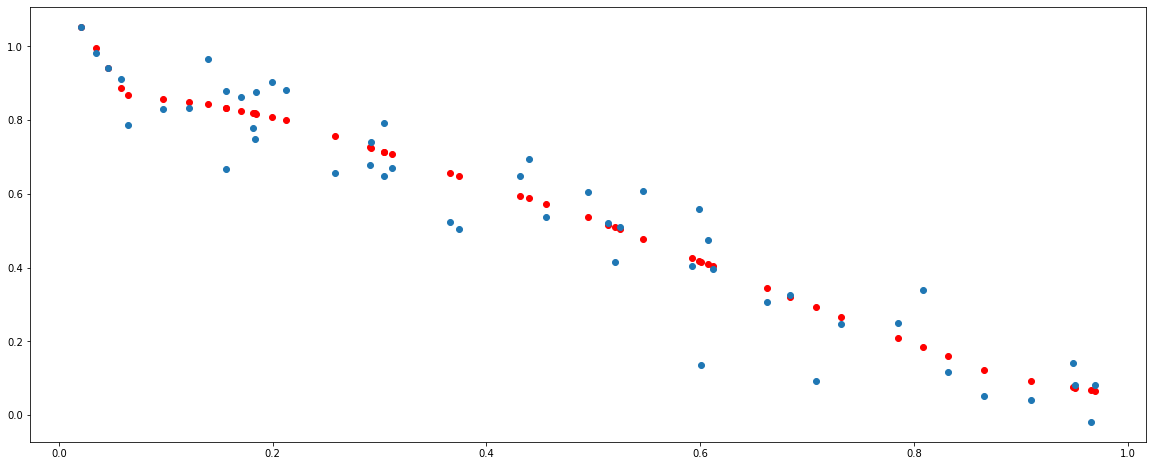

In [44]:
y_pred = model.predict(x)
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

## Second, non-linear example

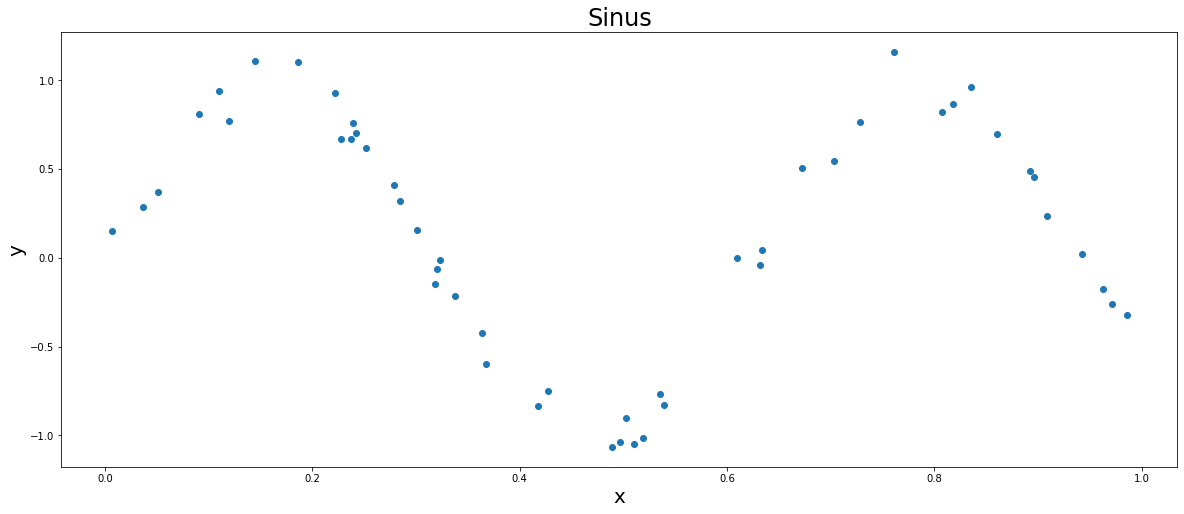

In [45]:
#@title A noisy sine curve { run: "auto", display-mode: "form" }

n = 50 #@param {type:"slider", min:10, max:500, step:1}
noise_level = 0.1 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
scale = 10 #@param {type:"slider", min:1, max:100, step:1}

import numpy as np

x = np.random.uniform(0, 1, n)
y = np.sin(x*scale) + np.random.normal(0, noise_level, n)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Sinus')

plt.scatter(x, y);

In [46]:
%%time 
 
model = tf.keras.Sequential([
  Dense(units=100, activation='relu', input_dim=1),                   
  Dense(units=100, activation='relu'),
  Dense(units=100, activation='relu'),                   
  Dense(units=1, activation='linear')                   
])
model.summary()

model.compile(loss=tf.losses.mean_squared_error, # mean squared error, unchanged from low level example
             optimizer=tf.keras.optimizers.Adam(), # SGD, unchanged from low level example
             metrics=[r2_metric]) # we can track the r2 metric over time

# does a similar thing internally as our loop from above
history = model.fit(x, y, epochs=1000, verbose=0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 20,501
Trainable params: 20,501
Non-trainable params: 0
_________________________________________________________________
CPU times: user 7.87 s, sys: 974 ms, total: 8.85 s
Wall time: 6.77 s


In [47]:
loss, r2 = model.evaluate(x, y, verbose=0)
loss, r2

(0.0050678253173828125, 0.9877094030380249)

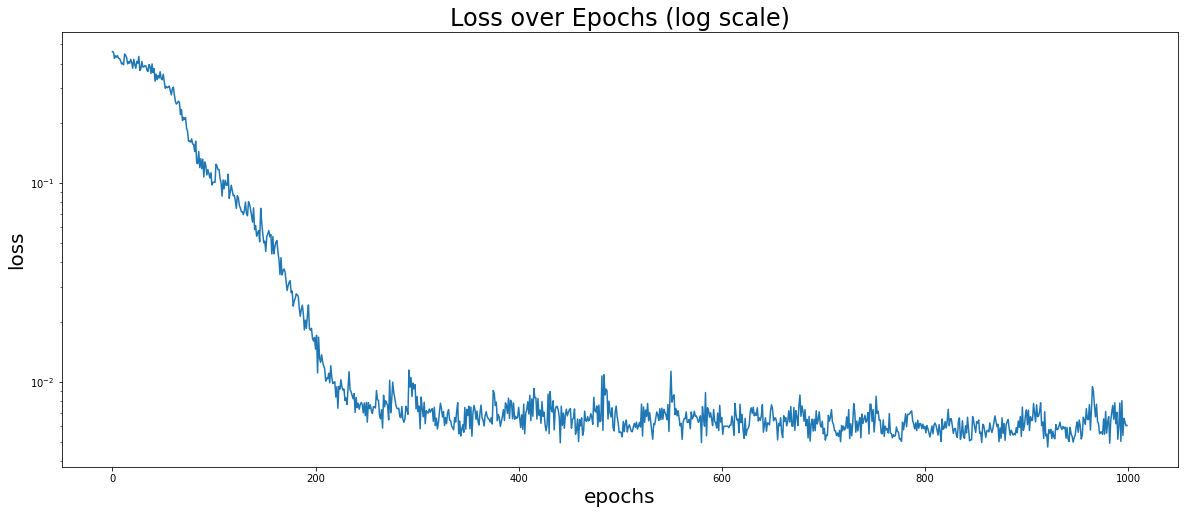

In [48]:
plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over Epochs (log scale)')

plt.plot(history.history['loss']);

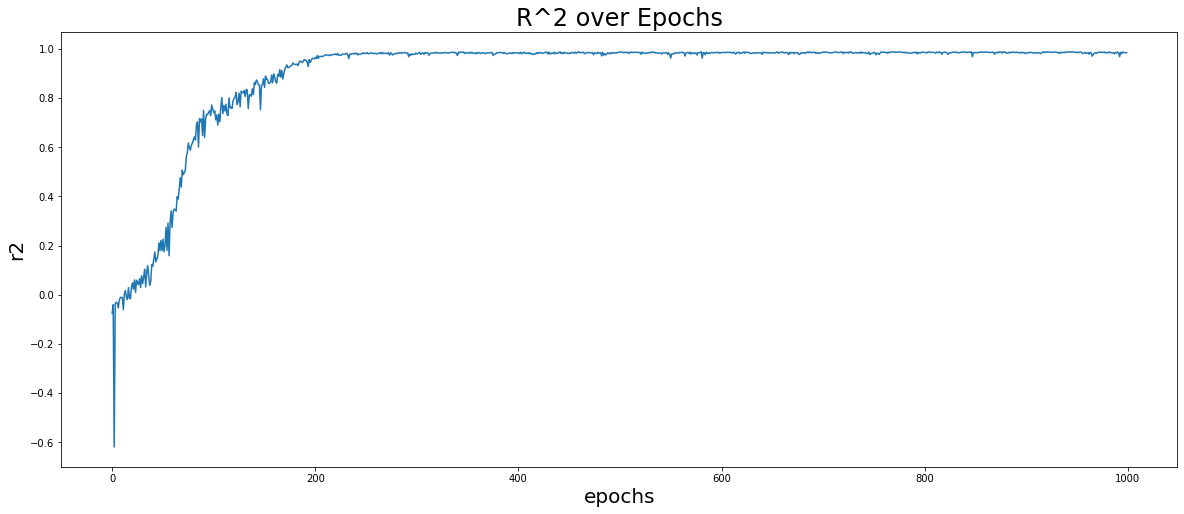

In [49]:
plt.ylabel("r2")
plt.xlabel("epochs")
plt.title('R^2 over Epochs')
# plt.yscale('log')

plt.plot(history.history['r2_metric']);

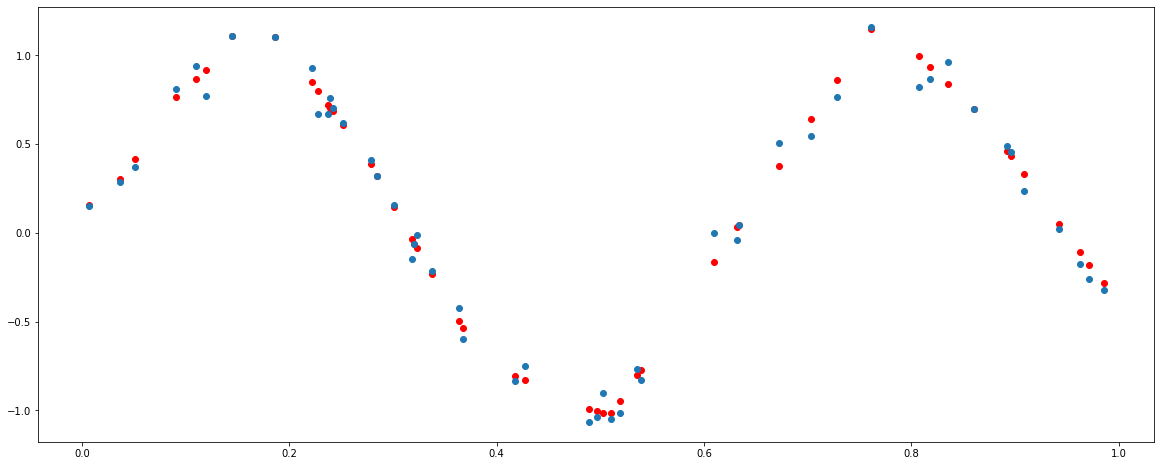

In [50]:
y_pred = model.predict(x)
plt.scatter(x, y_pred, color='red')
plt.scatter(x, y);

## Video Course

<a href='https://www.manning.com/livevideo/deep-learning-crash-course'>
<img src='https://github.com/djcordhose/deep-learning-crash-course-notebooks/blob/master/livevideo-deep-learning-crash-course.png?raw=1' height='200'>
</a>

https://www.manning.com/livevideo/deep-learning-crash-course, 40% off on all products using code **twitzeig40**

Oliver Zeigermann, <a href='http://zeigermann.eu/'>zeigermann.eu/</a>, <a href='https://twitter.com/DJCordhose'>@DJCordhose</a>
